<a href="https://colab.research.google.com/github/Rebel095/data_analysis/blob/main/Finding_useful_microconversions_for_conversion_strategy_in_Yandex_Direct.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Задача

В Яндекс Директ есть конверсионная стратегия, которая помогает рекламодателю получать максимальное количество целевых действий. Однако, чтобы она работала эффективно, ей нужно обучиться. Для обучения необходимо получать минимум 10 целевых действий в неделю.

В нашем случае это сайт по продаже недвижимости, где таких действий не так много. Поэтому нам нужно найти микроконверсии, которые коррелируют с нашей основной макроцелью. На основе этих микроконверсий и будет работать наша конверсионная стратегия.

## Подготовка


Необходимо выгрузить данные из Яндекс Метрики c с помощью [Logs Api](https://yandex.ru/dev/metrika/ru/logs/)

Logs API позволяет получать неагрегированные данные, собираемые Яндекс Метрикой. Данный API предназначен для пользователей сервиса, которые хотят самостоятельно обрабатывать статистические данные и использовать их для решения уникальных аналитических задач.

Также, предваритьельно нужно проверить в Яндекс Метрике корректно ли отслеживаются нужные нам цели, не было ли в анализируемом периоде каких-нибудь аномальных значений или потери данных по целям.

Выгружаем необходимые библиотеки

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import requests
import json
import time
from io import StringIO
from google.colab import files

Создадим список идентификаторов нужных микроконверсий (номера целей в Яндекс Метрике)

In [ ]:
microconversions_list = ['28216894', '232411775', '236431436', '238921945', '327927243', '327927273', '327927353', '327928979', '324943137']

Идентификатор нашей главной макроконверсии сохраним в переменной

In [ ]:
macroconversion_id = '201547996'

### Выгрузка данных из Яндекс Метрики по API

In [ ]:
TOKEN = 'ВАШ ТОКЕН' # у этого логина должен быть доступ к счётчику, чтобы можно было выгрузить статистику

**Для нашей задачи нужны следующие поля (**FIELDS**):**
* `ym:s:visitID` — Идентификатор визита
* `ym:s:counterUserIDHash` — Идентификатор посетителя (в рамках одного браузера), с помощью которого производится подсчет уникальных посетителей сайта в интерфейсе Метрики
* `ym:s:goalsID` - Номера целей, достигнутых за данный визит
* `ym:s:dateTime` - Дата и время визита (в часовом поясе счетчика)
* `ym:s:isNewUse`r - Первый визит посетителя

Примечание: Вместо `ym:s:goalsID` можно использовать и [параметры событий](https://yandex.ru/dev/metrika/ru/logs/fields/hits), но в нашем случае на сайте параметры событий не настроены должным образом и весь анализ мы строим на достижениях целей.

In [ ]:
COUNTER_ID = 12345678 # номер счётчика яндекс метрики
DATE1 = '2024-04-01'
DATE2 = '2025-02-28'
SOURCE = 'visits' # visits или hits
FIELDS = ['ym:s:visitID', 'ym:s:counterUserIDHash', 'ym:s:goalsID','ym:s:dateTime', 'ym:s:isNewUser'] # тут нужно перечислить поля
PARAM = {
        'date1': DATE1,
        'date2':DATE2,
        'source':SOURCE,
        'fields':','.join(FIELDS)

}


In [ ]:
# Оценка возможности создания запроса

# Этот метод оценивает возможность создания запроса логов по его примерному размеру.
# Дело в том, что по заданным параметрам в Яндекс.Метрике может храниться слишком большой объём данных.
# Он будет слишком долго подготавливаться на серверах Яндекс.Метрики.
# Потому существуют ограничения: для одного счётчика Яндекс.Метрики суммарный размер данных в запросе не превышает 10 ГБ.



URL = 'https://api-metrika.yandex.ru/management/v1/counter/{counter_id}/logrequests/evaluate?'\
        .format(counter_id=COUNTER_ID)



r = requests.get(URL,headers={'Authorization': 'OAuth {0}'.format(TOKEN)},params=PARAM)

r.text

In [ ]:
# Создание запроса логов
# Такие большие данные нельзя получить сразу!
# Сперва создают запрос логов: отправляют к API Яндекс.Метрики информацию о том, какой запрос хочется получить.
# Тогда сервера Яндекс.Метрики начнут его готовить.

URL = 'https://api-metrika.yandex.ru/management/v1/counter/{counter_id}/logrequests?'\
        .format(counter_id=COUNTER_ID)

r = requests.post(URL,headers={'Authorization': 'OAuth {0}'.format(TOKEN)},params=PARAM)

data = json.loads(r.text)
data

In [ ]:
# request_id —  это идентификатор запроса логов
request_id = data['log_request']['request_id']

In [ ]:
# После того, как был получен идентификатор запроса логов (request_id), можно проверить, готовы ли данные этого лога для загрузки.


status = 'created'
while status == 'created': # для продолжения требуется статус "processed", поэтому цикл будет выполняться пока не получим статус отличный от "created"
    time.sleep(60) # Если не предусмотреть «задержку» в выполнении алгоритма, то запросы будут отправляться слишком часто. А это противоречит политике сервиса: обычно существует ограничение на число запросов к сторонним API за одну секунду.
    print('trying')
    URL = 'https://api-metrika.yandex.ru/management/v1/counter/{counter_id}/logrequest/{request_id}'.format(
        counter_id=COUNTER_ID, request_id=request_id
    )
    r = requests.get(URL, headers={'Authorization': 'OAuth {0}'.format(TOKEN)})
    if r.status_code == 200:
        status = json.loads(r.text)['log_request']['status']
        print(json.dumps(json.loads(r.text)['log_request'], indent=4))

In [ ]:
# Загружаем лог

parts = json.loads(r.text)['log_request']['parts']
parts

[{'part_number': 0, 'size': 65065207},
 {'part_number': 1, 'size': 65080174},
 {'part_number': 2, 'size': 65372019},
 {'part_number': 3, 'size': 65145482},
 {'part_number': 4, 'size': 64978126},
 {'part_number': 5, 'size': 65096193},
 {'part_number': 6, 'size': 64913258}]

In [ ]:
# Это список словарей, где каждый содержит номер части и её размер.
# Чтобы пройтись циклом по номерам всех частей, сведём их в один список:
parts_list = []
for part in parts:
        parts_list.append(part['part_number'])

parts_list

[0, 1, 2, 3, 4, 5, 6]

In [ ]:
tmp_dfs = []
for part_num in parts_list:
    URL = 'https://api-metrika.yandex.ru/management/v1/counter/{counter_id}/logrequest/{request_id}/part/{part}/download'.format(
        counter_id=COUNTER_ID, request_id=request_id, part=part_num
    )

    r = requests.get(URL, headers={'Authorization': 'OAuth {0}'.format(TOKEN)})
    if r.status_code == 200:
        tmp_df = pd.read_csv(StringIO(r.text), sep='\t')  # StringIO
        tmp_dfs.append(tmp_df)

logs_df = pd.concat(tmp_dfs)

In [ ]:
logs_df

,ym:s:visitID,ym:s:counterUserIDHash,ym:s:goalsID,ym:s:dateTime,ym:s:isNewUser
0,5838693155540042024,8423628119783438554,[],2024-10-03 21:54:05,0
1,4328602211727442180,14767872891073482057,[],2024-07-29 05:45:07,1
2,4285173273306333263,2270341627917012458,[],2024-07-27 07:43:58,1
3,3529023273747611765,2222751855637584783,[327928979],2024-06-23 22:29:15,0
4,3771615307864473673,10564861927178687433,[],2024-07-04 15:32:50,0
...,...,...,...,...,...
860610,4515024751876112709,385210257187706588,[],2024-08-06 11:17:32,0
860611,5202798633839231113,11003893857697371980,"[327927273,327928979]",2024-09-05 20:05:01,1
860612,7078189146490536016,16857510996110689843,[],2024-11-27 15:19:08,0
860613,4989336042484269107,13703422634814135930,[],2024-08-27 09:53:26,1


На всякий случай лучше сохранить себе файлик на ПК, чтоб потом непришлось всё заново выгружать, если прерваться 😀

In [ ]:
logs_df.to_csv('logs_df.csv')
files.download('logs_df.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Тут мне пришлось прерваться и я уже далее данные обрабатывал из предварительно сохранённого файла csv

In [ ]:
logs_df = pd.read_csv('/content/logs_df (1).csv', sep=',',  dtype={'ym:s:visitID':str,'ym:s:counterUserIDHash':str, 'ym:s:goalsID':str, 'ym:s:isNewUser' :int}, index_col=0)


In [ ]:
logs_df = logs_df.rename(columns={'ym:s:visitID':'visit_id', 'ym:s:counterUserIDHash':'user_id', 'ym:s:goalsID':'goals_id','ym:s:dateTime':'date_time','ym:s:isNewUser':'new_user' })

Нам нужно выявить какие пользователи были новыми в анализируемом периоде.

У таких пользователей есть визиты с `new_user` равный 1

In [ ]:
df_new_users = logs_df.query('new_user == 1') # оставляем визиты только новых пользователей
df_new_users

,visit_id,user_id,goals_id,date_time,new_user
1,4328602211727442180,14767872891073482057,[],2024-07-29 05:45:07,1
2,4285173273306333263,2270341627917012458,[],2024-07-27 07:43:58,1
5,7243728555264180327,15044194151809596236,"[327928979,28216894]",2024-12-04 22:43:50,1
8,7009329755367145504,6538934551084699791,[],2024-11-24 14:21:11,1
10,4986371648498172087,10398416349520787692,[],2024-08-27 06:44:58,1
...,...,...,...,...,...
860607,4380153670162710875,5500113723375452065,"[327928979,28216894,327927243]",2024-07-31 12:22:40,1
860609,6129402199124475993,547216838179513778,"[327927353,327927353,327928979]",2024-10-16 17:56:53,1
860611,5202798633839231113,11003893857697371980,"[327927273,327928979]",2024-09-05 20:05:01,1
860613,4989336042484269107,13703422634814135930,[],2024-08-27 09:53:26,1


In [ ]:
# Значения в столбце goals_id выглядят как массивы, но они пока ещё не массивы на самом деле
# Разбиваем объект String на массив строк путём разделения строки указанной подстрокой.
logs_df['goals_id'] = logs_df.goals_id.apply(lambda x: x[1:-1].split(','))
logs_df

,visit_id,user_id,goals_id,date_time,new_user
0,5838693155540042024,8423628119783438554,[],2024-10-03 21:54:05,0
1,4328602211727442180,14767872891073482057,[],2024-07-29 05:45:07,1
2,4285173273306333263,2270341627917012458,[],2024-07-27 07:43:58,1
3,3529023273747611765,2222751855637584783,[327928979],2024-06-23 22:29:15,0
4,3771615307864473673,10564861927178687433,[],2024-07-04 15:32:50,0
...,...,...,...,...,...
860610,4515024751876112709,385210257187706588,[],2024-08-06 11:17:32,0
860611,5202798633839231113,11003893857697371980,"[327927273, 327928979]",2024-09-05 20:05:01,1
860612,7078189146490536016,16857510996110689843,[],2024-11-27 15:19:08,0
860613,4989336042484269107,13703422634814135930,[],2024-08-27 09:53:26,1


In [ ]:
# Выравниваем таблицу по нужным столбцам
logs_df = logs_df.explode(['goals_id']).reset_index(drop=True)
logs_df

,visit_id,user_id,goals_id,date_time,new_user
0,5838693155540042024,8423628119783438554,,2024-10-03 21:54:05,0
1,4328602211727442180,14767872891073482057,,2024-07-29 05:45:07,1
2,4285173273306333263,2270341627917012458,,2024-07-27 07:43:58,1
3,3529023273747611765,2222751855637584783,327928979,2024-06-23 22:29:15,0
4,3771615307864473673,10564861927178687433,,2024-07-04 15:32:50,0
...,...,...,...,...,...
9237568,5202798633839231113,11003893857697371980,327927273,2024-09-05 20:05:01,1
9237569,5202798633839231113,11003893857697371980,327928979,2024-09-05 20:05:01,1
9237570,7078189146490536016,16857510996110689843,,2024-11-27 15:19:08,0
9237571,4989336042484269107,13703422634814135930,,2024-08-27 09:53:26,1


In [ ]:
logs_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9237573 entries, 0 to 9237572
Data columns (total 5 columns):
 #   Column     Dtype 
---  ------     ----- 
 0   visit_id   object
 1   user_id    object
 2   goals_id   object
 3   date_time  object
 4   new_user   int64 
dtypes: int64(1), object(4)
memory usage: 352.4+ MB


Нас интересуют только те пользователи, которые в анализируемом периоде совершили нашу главную макроконверсию. События этих пользователей мы и будем потом анализировать.

In [ ]:
df_users_converted = logs_df.query('goals_id == @macroconversion_id') # выявляем тех, кто совершил конверсию
df_users_converted

,visit_id,user_id,goals_id,date_time,new_user
2007,1707160263016841492,9411422623421820500,201547996,2024-04-04 11:58:19,1
4490,2954030859883118829,5130289340461336240,201547996,2024-05-29 13:12:13,1
5585,2341803597736968428,4651698967728740047,201547996,2024-05-02 12:27:51,1
8799,6510044005794054352,16993138269402463674,201547996,2024-11-02 13:17:27,0
9130,3677341399363879029,18384163162013981856,201547996,2024-06-30 11:39:04,0
...,...,...,...,...,...
9206207,2836913350057394192,9699702187054832312,201547996,2024-05-24 09:06:05,1
9210513,2594088626597134405,9922968807218376930,201547996,2024-05-13 15:47:42,1
9218481,5217613861374394614,11722923328031113506,201547996,2024-09-06 11:46:57,1
9222801,2208462798502232133,798150728976330537,201547996,2024-04-26 15:10:16,1


Теперь мы можем создать отфильтрованный датафрейм, где будут только те, кто совершил конверсию и одновременно был новым в анализируемом периоде.

In [ ]:
# Оставляем в датафрейме только тех пользователей, которые в анализируемом периоде приходили первый раз и совершили конверсию.
logs_filtered= logs_df.query("user_id in @df_new_users.user_id and user_id in @df_users_converted.user_id").reset_index(drop=True)
logs_filtered

,visit_id,user_id,goals_id,date_time,new_user
0,3110692214167306262,1399372806343204460,,2024-06-05 11:12:29,0
1,5647422545504239661,5757725904383227803,327927353,2024-09-25 11:13:27,0
2,1707160263016841492,9411422623421820500,327928979,2024-04-04 11:58:19,1
3,1707160263016841492,9411422623421820500,28216894,2024-04-04 11:58:19,1
4,1707160263016841492,9411422623421820500,42074200,2024-04-04 11:58:19,1
...,...,...,...,...,...
35613,1917365067416863117,17490140511474122451,327927243,2024-04-13 18:42:47,0
35614,5819971478101950735,7190826926449967727,327927243,2024-10-03 02:03:49,0
35615,3903499136288948494,13370512327732848548,,2024-07-10 11:17:47,0
35616,3633572398162247913,13401213648258197760,,2024-06-28 13:16:18,0


In [ ]:
# Приводим дату к нужному типу
logs_filtered["date_time"] = pd.to_datetime(logs_filtered["date_time"], format='%Y-%m-%d %H:%M:%S')

In [ ]:
logs_filtered.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35618 entries, 0 to 35617
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   visit_id   35618 non-null  object        
 1   user_id    35618 non-null  object        
 2   goals_id   35618 non-null  object        
 3   date_time  35618 non-null  datetime64[ns]
 4   new_user   35618 non-null  int64         
dtypes: datetime64[ns](1), int64(1), object(3)
memory usage: 1.4+ MB


## Обработка данных и ответы на вопросы

### Сколько в среднем визитов проходит от первого посещения до макроконверсии

In [ ]:
# Фильтруем пользователей, которые достигли макроконверсии
df_filtered = logs_filtered[logs_filtered["goals_id"] == macroconversion_id]


# Получаем первый визит, когда пользователь достиг макроконверсии
first_visits = df_filtered.groupby("user_id")["date_time"].min().reset_index()

# Подсчитываем количество уникальных визитов для каждого пользователя до макроконверсии
visit_counts = logs_filtered[logs_filtered["user_id"].isin(first_visits["user_id"])].groupby("user_id")["visit_id"].nunique()

# Вычисляем среднее количество визитов
average_visits = visit_counts.mean()
average_visits

7.10562015503876

В среднем до нашей главной макроконверсии проходит около 7 визитов.

### Сколько дней проходит до макроконверсии

In [ ]:
# Находим дату первого визита для каждого пользователя
first_visit_dates = logs_filtered.groupby("user_id")["date_time"].min().reset_index()
first_visit_dates.rename(columns={"date_time": "first_visit_date"}, inplace=True)

# Находим дату первого появления цели macroconversion_id
macroconversion_goal_dates = logs_filtered[logs_filtered["goals_id"] == macroconversion_id].groupby("user_id")["date_time"].min().reset_index()
macroconversion_goal_dates.rename(columns={"date_time": "macroconversion_goal_dates"}, inplace=True)

# Объединяем данные
merged_data = pd.merge(first_visit_dates, macroconversion_goal_dates, on="user_id")

# Вычисляем разницу в днях
merged_data["days_to_macroconversion_goal"] = (merged_data["macroconversion_goal_dates"] - merged_data["first_visit_date"]).dt.days

# Среднее количество дней
average_days = merged_data["days_to_macroconversion_goal"].mean()
average_days

10.416666666666666

В среднем проходит около 10 дней до нашей макроконверсии.

**Вывод:**

В среднем от момента первого посещения сайта до нашей главной макроконверсии проходит 7 визитов на протяжении 10 дней. Это значит, что корреляционный анализ в нашем случае не подходит, поскольку он подразумевает линейную зависимость между переменными. То есть, при изменении одной переменной другая переменная должна изменяется последовательно.

В нашем же случае, основная макроконверсия и микроконверсии находятся в разных визитах, и данные сгруппированные по дате не выявят зависимость. Даже если сгруппировать данные по 10 дней (на основе среднего количества дней до макроконверсии), так как у разных пользователей разное время до конверсии, у кого-то микроконверсии будут в начале нашего сгруппированного периода, а у кого-то в конце этого периода.

Кроме того, для достижения статистической мощности 80% (то есть, высокой вероятности обнаружения реальной зависимости) требуется:

* Слабая корреляция (r = 0.1) → ~389 наблюдений
* Средняя корреляция (r = 0.3) → ~40 наблюдений
* Сильная корреляция (r = 0.5) → ~12 наблюдений

То есть, если одно наблюдение - это период в 10 дней, то для выявления средней корреляции потребуется 40 х 10 дней = 400 дней в нашем наборе данных.

Думаю, что в нашем случае с сайтом по продаже недвижимости лучше всего подойдёт **Анализ совместной встречаемости (Co-occurrence Analysis)**.


## Анализ совместной встречаемости (Co-occurrence Analysis)

Этот метод позволяет оценить, насколько часто два события происходят вместе. В качестве значений будем использовать маркеры:
* 1 - наличие события
* 0 - отсутствие события

В качестве наблюдения у нас будет идентификатор пользователя (а не дата), все-все его события до макроконверсии.
Для бинарных данных это более подходящий подход, чем корреляция.

**Шаги:**
1.   Создадим сводную таблицу, где в качестве значений будут наши маркеры
2.   Для каждого события (кроме главного) посчитаем, сколько раз оно происходило вместе с главным событием.
3.   Рассчитаем долю совместной встречаемости: количество раз, когда оба события произошли, поделив на общее количество случаев, когда произошло главное событие.


### Создаем сводную таблицу

При  создании `pivot_table` нельзя использоовать в качестве `values` то же самое, что у нас и в индексе. Выдаст ошибку. А нам нужно просто посчитать уникальных пользователей (у каждого пользователя будет только один `user_id` - наш маркер 1). Поэтому просто сделаем дубль нашего столбца `user_id`.

In [ ]:
logs_filtered['user_id_new'] = logs_filtered['user_id']

In [ ]:
table = pd.pivot_table(logs_filtered, values='user_id_new', index=['user_id'],
                       columns=['goals_id'], aggfunc="nunique", fill_value=0)
table = table.reset_index()
table

goals_id,user_id,,136231975,201547993,201547996,201547999,232090851,232090980,232091861,232411775,...,336295316,339160657,354962533,358824169,361486865,361488757,42074200,46482814,46483744,66557992
0,10002604905469735886,0,0,1,1,1,0,0,0,0,...,0,0,1,0,0,0,1,0,0,0
1,10014629827741008187,0,0,1,1,1,0,1,0,0,...,0,0,0,0,0,0,1,0,0,0
2,10049135800792303081,0,0,1,1,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,10050280110528554830,0,0,1,1,1,0,0,0,0,...,1,0,1,0,0,0,1,0,0,0
4,10084105559672482759,0,0,1,1,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1027,9884278227227392093,1,0,1,1,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1028,9897801854686971751,0,0,1,1,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1029,9904300781754044506,1,0,1,1,1,0,0,0,1,...,0,0,1,1,0,0,1,0,0,0
1030,9922968807218376930,0,0,1,1,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


У нас 1032 наблюдения (равное количеству уникальных `user_id` в нашем наборе данных). В колонках идентификаторы наших целей из Яндекс Метрики (микроконверсии + главная макроконверсия), в значениях — маркер было/не было события.

На всякий случай лучше сохранить себе файлик на ПК, чтоб потом непришлось всё заново считать, если прерваться 😀

In [ ]:
table.to_csv('table.csv')
files.download('table.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Рассчитываем долю совместной встречаемости

In [ ]:
# Создаем DataFrame для хранения совместной встречаемости
co_occurrence_matrix = pd.DataFrame(index=[macroconversion_id], columns=microconversions_list)

# Проходим по каждому событию и считаем совместную встречаемость
for event in microconversions_list:
    # Количество случаев, когда оба события произошли
    both_occurred = table[(table[macroconversion_id] == 1) & (table[event] == 1)].shape[0]
    # Общее количество случаев, когда произошло главное событие
    total_main_event = table[table[macroconversion_id] == 1].shape[0]
    # Доля совместной встречаемости
    co_occurrence_matrix.loc[macroconversion_id, event] = both_occurred / total_main_event if total_main_event > 0 else 0

# Преобразуем данные в числовой формат
co_occurrence_matrix = co_occurrence_matrix.astype(float)

In [ ]:
co_occurrence_matrix

,28216894,232411775,236431436,238921945,327927243,327927273,327927353,327928979,324943137
201547996,0.614341,0.042636,0.003876,0.04845,0.458333,0.371124,0.229651,0.794574,0.177326


In [ ]:
# Сортировка событий
co_occurrence_matrix = co_occurrence_matrix.sort_values(by=macroconversion_id, axis=1, ascending=False)

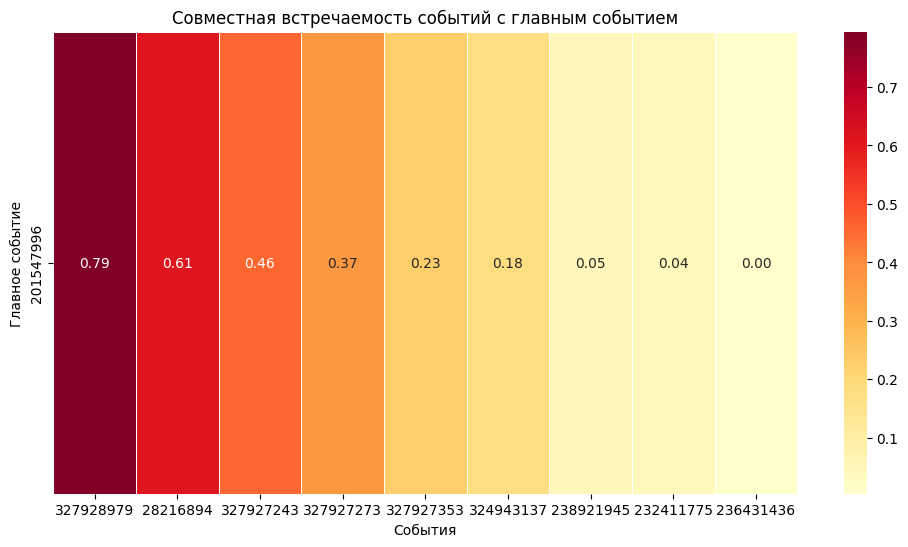

In [ ]:
# Визуализация тепловой карты
plt.figure(figsize=(12, 6))
sns.heatmap(co_occurrence_matrix, annot=True, cmap='YlOrRd', fmt='.2f', linewidths=0.5)
plt.title('Совместная встречаемость событий с главным событием')
plt.xlabel('События')
plt.ylabel('Главное событие')
plt.show()


**Интерпретация:**
* Высокая доля совместной встречаемости указывает на то, что событие часто происходит вместе с главным событием.

* Это может быть полезно для выявления событий, которые потенциально влияют на главное событие.

## Вывод

* Мы видим, что событие с идентификатором 327928979 совместно встречается с событием макроконверсии у 79% пользователей

* Событие 28216894 совместно встречается с событием макроконверсии у 61% пользователей

* Событие 327927243 совместно встречается с событием макроконверсии у 46% пользователей.

Рекомендуется использовать эти микроцели в настройке стратегий в Яндекс Директе с оплатой за конверсии.

Также, рекомендуется настроить сбор дополнительных событий с сайта. Можно попробовать найти ещё другие события, которые совместно используются с главной целью.